# Cleaning

This notebook illustrates detailed download and cleaning of the Chicago Crash data. 

Our Problem focused on what factors contribute to **severe** traffic incidents at **night**. 

* **Severe** traffic incidents we defined as `FATAL` or `INCAPACITATING` from the `INJURY_TYPE` column. 

* **Night** we defined as the hours between 10pm to 5 am, or hours `22` through `5` in the `CRASH_HOUR` column. 

* Final output is `final_df` which will be used in the following notebook(s).

### Loading the Neccessary Packages and CSV Files

In [1]:
#Importing the neccessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree




In [2]:
crash_df = pd.read_csv('data/Traffic_Crashes_-_crashes.csv')
people_df = pd.read_csv('data/Traffic_Crashes_-_people.csv', low_memory=False)

### Dropping Unneccessary Columns

#### `crash_df` dropping Justification: 

* `RD_NO` - Police Dep. Report number, another identifying number associated with each record, we kept `CRASH_RECORD_ID` as the joining record number for each dataframe. 
* `CRASH_DATE_EST_I` - used when crash is reported to police days after the crash, this dataframe inclues crash day of week, hour and month so we can drop the specific date.
* `CRASH_DATE` - this dataframe inclues crash day of week, hour and month so we can drop the specific date.
* `REPORT_TYPE` - administrative report type, not a factor relevant to causing a crash.
* `HIT_AND_RUN_I` - not a factor relevant to causing a crash.
* `DATE_POLICE_NOTIFIED` - not a factor relevant to causing a crash.
* `STREET_NO` - of location related data we chose to keep latitude, longitude
* `BEAT_OF_OCCURENCE` - not a factor relevant to causing a crash.
* `PHOTOS_TAKEN_I` - not a factor relevant to causing a crash.
* `STATEMENTS_TAKEN` - not a factor relevant to causing a crash.
* `MOST_SEVERE_INJURY` - basing our severity of injury off of information from the `people_df` dataframe, including this and other injury related columns would cause multicolliniarity in our modeling. 
* `INJURIES_FATAL`
* `INJURIES_NON_INCAPACITATING`
* `INJURIES_REPORTED_NOT_EVIDENT`
* `INJURIES_NO_INDICATION`
* `INJURIES_UNKNOWN`
* `LONGITUDE`
* `LATITUDE`

In [3]:
crash_df_cleaned = crash_df[['CRASH_RECORD_ID', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 
                                          'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'LANE_CNT', 
                                          'ROADWAY_SURFACE_COND', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH']]

In [4]:
crash_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554228 entries, 0 to 554227
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   CRASH_RECORD_ID         554228 non-null  object 
 1   TRAFFIC_CONTROL_DEVICE  554228 non-null  object 
 2   DEVICE_CONDITION        554228 non-null  object 
 3   WEATHER_CONDITION       554228 non-null  object 
 4   LIGHTING_CONDITION      554228 non-null  object 
 5   LANE_CNT                198970 non-null  float64
 6   ROADWAY_SURFACE_COND    554228 non-null  object 
 7   CRASH_HOUR              554228 non-null  int64  
 8   CRASH_DAY_OF_WEEK       554228 non-null  int64  
 9   CRASH_MONTH             554228 non-null  int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 42.3+ MB


#### `people_df` dropping Justification: 

* `PERSON_ID` - unique ID for each person record, 

... do we need to fill in reasons for all these? 

In [5]:
people_df_cleaned = people_df[['CRASH_RECORD_ID', 'AGE', 
                               'BAC_RESULT VALUE', 'INJURY_CLASSIFICATION']]

## Subsetting crash records between 10 pm and 6 am

In [6]:
night_time_df = crash_df_cleaned.copy()
night_time_df = night_time_df[(night_time_df['CRASH_HOUR'] >= 22) | (night_time_df['CRASH_HOUR'] <= 6)]
night_time_df.columns

Index(['CRASH_RECORD_ID', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'LANE_CNT',
       'ROADWAY_SURFACE_COND', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK',
       'CRASH_MONTH'],
      dtype='object')

## Joining all two data sets

In [7]:
#checking the shape
night_time_df.shape, people_df_cleaned.shape

((93448, 10), (1224613, 4))

In [8]:
merge = pd.merge(night_time_df, people_df_cleaned, how='left', on='CRASH_RECORD_ID')
merge.shape

(188733, 13)

## Further Exploring Columns

#### `INJURY_CLASSIFICATION` target Variable - this includes all people involved in incident, cyclists, passengers, drivers, etc. 

In [9]:
merge['INJURY_CLASSIFICATION'].value_counts()

NO INDICATION OF INJURY     166735
NONINCAPACITATING INJURY     12730
REPORTED, NOT EVIDENT         5501
INCAPACITATING INJURY         2834
FATAL                          310
Name: INJURY_CLASSIFICATION, dtype: int64

In [10]:
# fatal / incapacitate = 1
merge.loc[(merge['INJURY_CLASSIFICATION'] == 'FATAL') | 
           (merge['INJURY_CLASSIFICATION'] == 'INCAPACITATING INJURY'), 'INJURY_CLASSIFICATION'] = 1

# else = 0
merge.loc[(merge['INJURY_CLASSIFICATION'] == 'NO INDICATION OF INJURY') | 
           (merge['INJURY_CLASSIFICATION'] == 'NONINCAPACITATING INJURY') |
           (merge['INJURY_CLASSIFICATION'] == 'REPORTED, NOT EVIDENT'), 'INJURY_CLASSIFICATION'] = 0

merge['INJURY_CLASSIFICATION'].fillna(0, inplace=True)

In [11]:
merge["INJURY_CLASSIFICATION"].value_counts(normalize=True)

0    0.983342
1    0.016658
Name: INJURY_CLASSIFICATION, dtype: float64

In [12]:
merge = merge.drop(columns=['CRASH_RECORD_ID'])

### changing traffic control device

In [13]:
merge.loc[merge['TRAFFIC_CONTROL_DEVICE'] == 'NO CONTROLS', 'TRAFFIC_CONTROL_DEVICE'] = 0
merge.loc[merge['TRAFFIC_CONTROL_DEVICE'] != 0, 'TRAFFIC_CONTROL_DEVICE'] = 1

merge.loc[merge.DEVICE_CONDITION == 'FUNCTIONING PROPERLY', 'DEVICE_CONDITION'] = 1
merge.loc[merge.DEVICE_CONDITION != 1, 'DEVICE_CONDITION'] = 0

merge['DEVICE_CONDITION'] = merge['DEVICE_CONDITION'].astype(float)
merge['TRAFFIC_CONTROL_DEVICE'] = merge['TRAFFIC_CONTROL_DEVICE'].astype(float)

### changing weather

In [14]:
# 1 is clear
merge.loc[merge['WEATHER_CONDITION'] == 'CLEAR', 'WEATHER_CONDITION'] = 1

# 0 is not clear
merge.loc[merge['WEATHER_CONDITION'] != 1, 'WEATHER_CONDITION'] = 0

merge['WEATHER_CONDITION'] = merge['WEATHER_CONDITION'].astype(float)

### changing lighting condition

In [15]:
# ohe this during train test split

In [16]:
merge['LIGHTING_CONDITION'].value_counts()

DARKNESS, LIGHTED ROAD    129456
DAYLIGHT                   21619
DARKNESS                   20302
DAWN                        8099
UNKNOWN                     6812
DUSK                        2445
Name: LIGHTING_CONDITION, dtype: int64

### changing lane count

In [17]:
index = merge[merge['LANE_CNT'] > 12].index

merge.drop(index, inplace=True)

In [18]:
merge.fillna(merge['LANE_CNT'].median(), inplace=True)

### changing roadway surface cond

In [19]:
merge.loc[merge['ROADWAY_SURFACE_COND'] == 'OTHER', 'ROADWAY_SURFACE_COND'] = 'UNKNOWN'

### changing bac_result value TODO

In [20]:
merge['BAC_RESULT VALUE'].value_counts()

2.00    187734
0.17        78
0.18        76
0.14        63
0.21        60
0.00        60
0.20        57
0.16        54
0.15        50
0.11        45
0.22        45
0.19        44
0.13        42
0.12        42
0.24        30
0.23        25
0.09        23
0.10        23
0.25        18
0.26        15
0.27        12
0.07        12
0.28        11
0.03        10
0.04         9
0.08         9
0.30         7
0.05         6
0.06         5
0.29         5
0.38         4
0.33         3
0.02         3
1.00         2
0.31         2
0.01         2
0.35         1
0.45         1
0.44         1
0.79         1
0.32         1
0.58         1
0.60         1
0.67         1
0.88         1
0.95         1
Name: BAC_RESULT VALUE, dtype: int64

### changing age TODO

In [21]:
merge['AGE'].value_counts()

 2.0      65340
 26.0      4786
 24.0      4677
 25.0      4659
 27.0      4537
          ...  
 92.0         2
-1.0          2
 100.0        1
 104.0        1
 108.0        1
Name: AGE, Length: 100, dtype: int64

In [22]:
merge['AGE'] = merge['AGE'].abs()

## compile final df

In [23]:
final_df = merge.copy()
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188696 entries, 0 to 188732
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   TRAFFIC_CONTROL_DEVICE  188696 non-null  float64
 1   DEVICE_CONDITION        188696 non-null  float64
 2   WEATHER_CONDITION       188696 non-null  float64
 3   LIGHTING_CONDITION      188696 non-null  object 
 4   LANE_CNT                188696 non-null  float64
 5   ROADWAY_SURFACE_COND    188696 non-null  object 
 6   CRASH_HOUR              188696 non-null  int64  
 7   CRASH_DAY_OF_WEEK       188696 non-null  int64  
 8   CRASH_MONTH             188696 non-null  int64  
 9   AGE                     188696 non-null  float64
 10  BAC_RESULT VALUE        188696 non-null  float64
 11  INJURY_CLASSIFICATION   188696 non-null  int64  
dtypes: float64(6), int64(4), object(2)
memory usage: 18.7+ MB


#### Exporting the `final_df` into csv file

In [24]:
clean_data = final_df.to_csv('clean_data.csv', index = False)

## first model

### train test split

In [25]:
X = final_df.drop(columns=['INJURY_CLASSIFICATION'])
#X = final_df[['LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND']]
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### ohe_train

In [26]:
ohe = OneHotEncoder(sparse=False)

ohe.fit(X_train[['LIGHTING_CONDITION']])
feature_names = ohe.get_feature_names()
X_train_ohe = ohe.transform(X_train[['LIGHTING_CONDITION']])

In [27]:
X_train_ohe = pd.DataFrame(X_train_ohe, index=X_train.index)

In [28]:
X_train_new = pd.concat([X_train, X_train_ohe], axis=1)

In [29]:
X_train_new.rename({0:'L_DARKNESS', 1:'L_DARKNESS, LIGHTED ROAD', 2:'L_DAWN', 3:'L_DAYLIGHT', 
                    4:'L_DUSK', 5:'L_UNKNOWN'}, axis=1, inplace=True)

In [30]:
ohe.fit(X_train[['ROADWAY_SURFACE_COND']])
feature_names = ohe.get_feature_names()
X_train_ohe = ohe.transform(X_train[['ROADWAY_SURFACE_COND']])
X_train_ohe = pd.DataFrame(X_train_ohe, index=X_train.index)

In [31]:
X_train_concat = pd.concat([X_train_new, X_train_ohe], axis=1)

In [32]:
X_train_concat.rename({0:'W_DRY', 1:'W_ICE', 2:'W_SAND, MUD, DIRT', 3:'W_SNOW OR SLUSH', 
                       4:'W_UNKNOWN', 5:'W_WET'}, axis=1, inplace=True)

In [33]:
X_train = X_train_concat.copy()

### ohe x_test

In [34]:
X_test.columns

Index(['TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION',
       'LIGHTING_CONDITION', 'LANE_CNT', 'ROADWAY_SURFACE_COND', 'CRASH_HOUR',
       'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'AGE', 'BAC_RESULT VALUE'],
      dtype='object')

In [35]:
ohe = OneHotEncoder(sparse=False)

ohe.fit(X_train[['LIGHTING_CONDITION']])
feature_names = ohe.get_feature_names()
X_test_ohe = ohe.transform(X_test[['LIGHTING_CONDITION']])

In [36]:
X_test_ohe = pd.DataFrame(X_test_ohe, index=X_test.index)

In [37]:
X_test_new = pd.concat([X_test, X_test_ohe], axis=1)

In [38]:
X_test_new.rename({0:'L_DARKNESS', 1:'L_DARKNESS, LIGHTED ROAD', 2:'L_DAWN', 3:'L_DAYLIGHT', 
                    4:'L_DUSK', 5:'L_UNKNOWN'}, axis=1, inplace=True)

In [39]:
ohe.fit(X_train[['ROADWAY_SURFACE_COND']])
feature_names = ohe.get_feature_names()
X_test_ohe = ohe.transform(X_test[['ROADWAY_SURFACE_COND']])
X_test_ohe = pd.DataFrame(X_test_ohe, index=X_test.index)

In [40]:
X_test_concat = pd.concat([X_test_new, X_test_ohe], axis=1)

In [41]:
X_test_concat.rename({0:'W_DRY', 1:'W_ICE', 2:'W_SAND, MUD, DIRT', 3:'W_SNOW OR SLUSH', 
                       4:'W_UNKNOWN', 5:'W_WET'}, axis=1, inplace=True)

In [42]:
X_test = X_test_concat.copy()

In [43]:
X_test.drop(columns=['LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND'], inplace=True)

In [44]:
X_train.drop(columns=['LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND'], inplace=True)

### actually modeling

In [45]:
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

Feature 0: 4.363419
Feature 1: 12.137547
Feature 2: 7.629039
Feature 3: 6.740505
Feature 4: 256.716959
Feature 5: 8.763694
Feature 6: 4.770489
Feature 7: 5731.207100
Feature 8: 0.131256
Feature 9: 9.112004
Feature 10: 25.397438
Feature 11: 0.280227
Feature 12: 28.581816
Feature 13: 4.319783
Feature 14: 42.592832
Feature 15: 9.871919
Feature 16: 0.009939
Feature 17: 0.893000
Feature 18: 30.818501
Feature 19: 39.497593
Feature 20: 0.027845


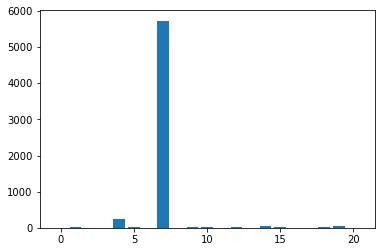

In [46]:
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [47]:
X_train.iloc[:, 7].value_counts()

2.0      49189
26.0      3573
24.0      3530
25.0      3431
27.0      3416
         ...  
92.0         2
109.0        2
108.0        1
100.0        1
104.0        1
Name: AGE, Length: 99, dtype: int64

<BarContainer object of 9 artists>

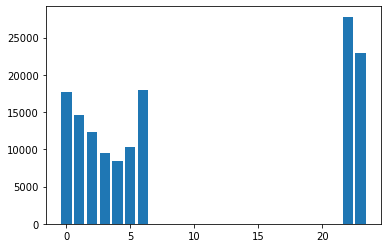

In [48]:
fig, ax = plt.subplots()

ax.bar(list(X_train.iloc[:, 4].value_counts().index), X_train.iloc[:, [4]].value_counts().values)